In [1]:
# !pip install requests
# !pip install psychrochart
# !pip install pandas
# !pip install -U ladybug-core
# !pip install git+https://github.com/Yoshiki443/weather_parameters
import dash
import requests
import json
import csv
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import math as math
from matplotlib import rcParams

C:\Users\81803\AppData\Local\Temp/ipykernel_30064/1046903609.py:10: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\81803\AppData\Local\Temp/ipykernel_30064/1046903609.py:11: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [2]:
#Jsonデータを読み込む

#JsonDataの中で、結果を算出
def getResultData(id):
    try:
        response = requests.get(f'https://oyster-app-8jboe.ondigitalocean.app/therb/{id}')
        data = json.loads(response.text)
        return data['data']
    except:
        throw('no id matches data in database')

#結果データをKeyごとにデータを変換
def dataFrameByKey(resultDataList,columnName):
    tempData = []
    columns=[]
    for resultData in resultDataList:
        df = convertToDataframe(resultData["results"])
        try:
            tempData.append(df[columnName])
            columns.append(resultData["roomId"])
        except:
            pass
    df=pd.concat(tempData,axis=1)
    df.columns = columns
    return df

#結果データをPandasで使えるようにする
def convertToDataframe(resultDict):
    columns = []
    rows = []
    for k,v in resultDict.items():
        columns.append(k)
        rows.append(v)
    #ここで、n行1列を1行n列に変換している(Pandasのデータ構造に合わせる為)
    transposedRows = np.array(rows).T
    df = pd.DataFrame(data = transposedRows, columns = columns) 
    df=df.set_index('time')
    df=df.astype('float32')
    return df

#結果データをKeyごとにデータを変換
#JsonDataの中で、各要素の面積を算出
def getAreaResultData(id):
    try:
        response = requests.get(f'https://oyster-app-8jboe.ondigitalocean.app/geometry/{id}')
        data = json.loads(response.text)
        return data
    except:
        throw('no id matches data in database')

#JsonDataの中で、各要素の物性値を算出
def getConstructResultData():
    try:
        response = requests.get(f'https://stingray-app-vgak2.ondigitalocean.app/envelopes')
        data = json.loads(response.text)
        return data
    except:
        throw('no id matches data in database')

#JsonDataの中で、各要素の物性値を算出
def getConstruct():
    try:
        response = requests.get(f'https://stingray-app-vgak2.ondigitalocean.app/constructions')
        data = json.loads(response.text)
        return data
    except:
        throw('no id matches data in database')



In [3]:
#湿り空気線図を作るデータの為の関数
#配列を生成
def dfArray(df,roomId):
    df=df[roomId]
    array=[]
    for i in range(len(df.index)):
        array.append(df.iloc[i])
    return array

#平均外気温度を算出する
def Outdoorenvironmentalresults(id):
    ResultData=getResultData(id)
    tempdictdf=dataFrameByKey(ResultData,"temp")
    outdoordf=tempdictdf["outdoor"]
    meanTemperature=round(outdoordf.mean(),2)
    return meanTemperature

#気象ポテンシャルにおけるpassivelolarにおける暖房期間(11/1~4/1)期間の最高気温を算出
def calcHighestTempinHeatPeriod(id):
    resultData=getResultData(id)
    tempdf=dataFrameByKey(resultData,"temp")["outdoor"]
    tdfa=tempdf.drop(index=tempdf["04/01/1:00":"10/31/24:00"].index)
    value=tdfa.sort_values(ascending=False)[0]
    return value

#気象ポテンシャルを評価する為の図式化を行う為の方程式
def PassiveMethodformula(method,meanTemperature):
    PassiveDict={"ActiveSolar":-1.9,"PassiveSolar":2.1,"InternalGain":6.6,"Winter":12.1,"Com1":14.1,"Com2":19.1,"Com3":21.1,"NaturalVentilation":26.1}
    #Search=input("ActiveSolar,PassiveSolar,InternalGain,Winter,Com1,Com2,Com3,NaturalVentilationから選択：")
    #NaturalVentilation、Comだったら領域になるので注意
    SelectMethod=PassiveDict[str(method)]
    Value=SelectMethod+0.31*meanTemperature
    Value=round(Value,2)
    return Value

#図式化を行うための具体的な値
def PassiveMethodValue(id):
    ActiveSolar=PassiveMethodformula("ActiveSolar",Outdoorenvironmentalresults(id))
    PassiveSolar=PassiveMethodformula("PassiveSolar",Outdoorenvironmentalresults(id))
    InternalGain=PassiveMethodformula("InternalGain",Outdoorenvironmentalresults(id))
    NaturalVentilation=PassiveMethodformula("NaturalVentilation",Outdoorenvironmentalresults(id))
    Winter=PassiveMethodformula("Winter",Outdoorenvironmentalresults(id))
    Com1=PassiveMethodformula("Com1",Outdoorenvironmentalresults(id))
    Com2=PassiveMethodformula("Com2",Outdoorenvironmentalresults(id))
    Com3=PassiveMethodformula("Com3",Outdoorenvironmentalresults(id))
    ComHalf=(Com2+Com3)/2
    NaturalHalf=(Com3+NaturalVentilation)/2
    Result={"NaturalHalf":NaturalHalf,"ComHalf":ComHalf,"ActiveSolar":ActiveSolar,"PassiveSolar":PassiveSolar,"InternalGain":InternalGain,
            "Winter":Winter,"Com1":Com1,"Com2":Com2,"Com3":Com3,"NaturalVentilation":NaturalVentilation}
    return Result

#野外のポテンシャルを図るためのZoneを生成
def OutdoorZone(id):
    result=PassiveMethodValue(id)
    #CreateZone
    zones_conf = {
        "zones":[{
                "zone_type": "dbt-rh",
                "style": {"edgecolor": [0, 0, 0, 1],
                          "facecolor": [0.66, 0.66, 0.66, 0.1],
                          "linewidth": 2,
                          "linestyle": "--"},
                "points_x": [result["InternalGain"], result["Winter"]],
                "points_y": [20, 80],
                "label": "InternalGain"
    },
                {
                "zone_type": "dbt-rh",
                "style": {"edgecolor": [0.275, 0.51, 0.71, 1],
                          "facecolor": [0.275, 0.51, 0.71, 0.1],
                          "linewidth": 2,
                          "linestyle": "--"},
                "points_x": [result["Winter"],result["Com1"]],
                "points_y": [20, 80],
                "label": "Winter"
    },
    {
                "zone_type": "dbt-rh",
                "style": {"edgecolor": [1.0, 1.0, 0.00, 1],
                          "facecolor": [1.0, 1.0, 0.00, 0.5],
                          "linewidth": 3,
                          "linestyle": "--"},
                "points_x": [result["Com1"], result["ComHalf"]],
                "points_y": [20, 80],
                "label": "Comfort"
    },
    {
                "zone_type": "dbt-rh",
                "style": {"edgecolor": [0.34, 0.72, 0.05, 1],
                          "facecolor": [0.34, 0.72, 0.05, 0.1],
                          "linewidth": 3,
                          "linestyle": "--"},
                "points_x": [result["Com1"],result["NaturalHalf"] ],
                "points_y": [20,80],
                "label": "NaturalVentilation"
    } ]}
    return zones_conf

In [4]:
#湿り空気線図を作るデータの為の関数
#配列を生成
def dfArray(df,roomId):
    df=df[roomId]
    array=[]
    for i in range(len(df.index)):
        array.append(df.iloc[i])
    return array

#平均外気温度を算出する
def Outdoorenvironmentalresults(id):
    ResultData=getResultData(id)
    tempdictdf=dataFrameByKey(ResultData,"temp")
    outdoordf=tempdictdf["outdoor"]
    meanTemperature=round(outdoordf.mean(),2)
    return meanTemperature

#気象ポテンシャルにおけるpassivelolarにおける暖房期間(11/1~4/1)期間の最高気温を算出
def calcHighestTempinHeatPeriod(id):
    resultData=getResultData(id)
    tempdf=dataFrameByKey(resultData,"temp")["outdoor"]
    tdfa=tempdf.drop(index=tempdf["04/01/1:00":"10/31/24:00"].index)
    value=tdfa.sort_values(ascending=False)[0]
    return value

#気象ポテンシャルを評価する為の図式化を行う為の方程式
def PassiveMethodformula(method,meanTemperature):
    PassiveDict={"ActiveSolar":-1.9,"PassiveSolar":2.1,"InternalGain":6.6,"Winter":12.1,"Com1":14.1,"Com2":19.1,"Com3":21.1,"NaturalVentilation":26.1}
    #Search=input("ActiveSolar,PassiveSolar,InternalGain,Winter,Com1,Com2,Com3,NaturalVentilationから選択：")
    #NaturalVentilation、Comだったら領域になるので注意
    SelectMethod=PassiveDict[str(method)]
    Value=SelectMethod+0.31*meanTemperature
    Value=round(Value,2)
    return Value

#図式化を行うための具体的な値
def PassiveMethodValue(id):
    ActiveSolar=PassiveMethodformula("ActiveSolar",Outdoorenvironmentalresults(id))
    PassiveSolar=PassiveMethodformula("PassiveSolar",Outdoorenvironmentalresults(id))
    InternalGain=PassiveMethodformula("InternalGain",Outdoorenvironmentalresults(id))
    NaturalVentilation=PassiveMethodformula("NaturalVentilation",Outdoorenvironmentalresults(id))
    Winter=PassiveMethodformula("Winter",Outdoorenvironmentalresults(id))
    Com1=PassiveMethodformula("Com1",Outdoorenvironmentalresults(id))
    Com2=PassiveMethodformula("Com2",Outdoorenvironmentalresults(id))
    Com3=PassiveMethodformula("Com3",Outdoorenvironmentalresults(id))
    ComHalf=(Com2+Com3)/2
    NaturalHalf=(Com3+NaturalVentilation)/2
    Result={"NaturalHalf":NaturalHalf,"ComHalf":ComHalf,"ActiveSolar":ActiveSolar,"PassiveSolar":PassiveSolar,"InternalGain":InternalGain,
            "Winter":Winter,"Com1":Com1,"Com2":Com2,"Com3":Com3,"NaturalVentilation":NaturalVentilation}
    return Result

#野外のポテンシャルを図るためのZoneを生成
def OutdoorZone(id):
    result=PassiveMethodValue(id)
    #CreateZone
    zones_conf = {
        "zones":[{
                "zone_type": "dbt-rh",
                "style": {"edgecolor": [0, 0, 0, 1],
                          "facecolor": [0.66, 0.66, 0.66, 0.1],
                          "linewidth": 2,
                          "linestyle": "--"},
                "points_x": [result["InternalGain"], result["Winter"]],
                "points_y": [20, 80],
                "label": "InternalGain"
    },
                {
                "zone_type": "dbt-rh",
                "style": {"edgecolor": [0.275, 0.51, 0.71, 1],
                          "facecolor": [0.275, 0.51, 0.71, 0.1],
                          "linewidth": 2,
                          "linestyle": "--"},
                "points_x": [result["Winter"],result["Com1"]],
                "points_y": [20, 80],
                "label": "Winter"
    },
    {
                "zone_type": "dbt-rh",
                "style": {"edgecolor": [1.0, 1.0, 0.00, 1],
                          "facecolor": [1.0, 1.0, 0.00, 0.5],
                          "linewidth": 3,
                          "linestyle": "--"},
                "points_x": [result["Com1"], result["ComHalf"]],
                "points_y": [20, 80],
                "label": "Comfort"
    },
    {
                "zone_type": "dbt-rh",
                "style": {"edgecolor": [0.34, 0.72, 0.05, 1],
                          "facecolor": [0.34, 0.72, 0.05, 0.1],
                          "linewidth": 3,
                          "linestyle": "--"},
                "points_x": [result["Com1"],result["NaturalHalf"] ],
                "points_y": [20,80],
                "label": "NaturalVentilation"
    } ]}
    return zones_conf

In [5]:
#快適指標に関するコード
#Clo値を計算する
def calcClovalue(summerClovalue,winterClovalue):
    #4月1日は2041番目 11月1日1時は7177番目,合計のデータ数は8521個
    a=[winterClovalue]*8521
    for i in range(2041,7177,1):
        a[i]=summerClovalue
    #df=dataFrameByKey(getResultData(60),"relHumidity")
    #A=df.index.get_loc('11/01/01:00')
    return a

#PMV*を計算する。
def CalculatePMV_PPD(id):
    from pythermalcomfort.models import pmv_ppd
    from pythermalcomfort.models import pmv
    from pythermalcomfort.utilities import v_relative, clo_dynamic
    #create Humiditydict,tempDict
    resultData = getResultData(id)
    temperaturedf=dataFrameByKey(resultData,"temp")
    humiditydf=dataFrameByKey(resultData,"relHumidity")
    tempDict={}
    humidityDict={}
    CalculateComfort={}
    for roomId in temperaturedf.columns:
        #print(roomId)
        if roomId != "outdoor":
            tempDict[roomId]= temperaturedf[roomId].tolist()
            humidityDict[roomId]=humiditydf[roomId].tolist()
            tdb = tempDict[roomId]
            tr = tempDict[roomId]
            rh = humidityDict[roomId]
            v = 0.1
            met = 1
            clo = calcClovalue(0.6,1.2)
            #print (tdb)
            # calculate relative air speed
            v_r = v_relative(v=v, met=met)
#             # calculate dynamic clothing
#             clo_d = clo_dynamic(clo, met, standard='ASHRAE')
            results = pmv_ppd(tdb=tdb, tr=tr, vr=v_r, rh=rh, met=met, clo=clo, limit_inputs=False)
            CalculateComfort[str(roomId)]= results
#             CalculateComfort[str(roomId)]["time"]=resultData[0]["results"]["time"]
            CalculateComfort[str(roomId)]["cloValue"]=clo
    return CalculateComfort

#SET*を計算する。
def CalculateSET(id):
    from pythermalcomfort.models import set_tmp
    from pythermalcomfort.utilities import v_relative, clo_dynamic
    #create Humiditydict,tempDict
    resultData = getResultData(id)
    temperaturedf=dataFrameByKey(resultData,"temp")
    humiditydf=dataFrameByKey(resultData,"relHumidity")
    tempDict={}
    humidityDict={}
    CalculateComfort={}
    for roomId in temperaturedf.columns:
        if roomId != "outdoor":
            tempDict[roomId]= temperaturedf[roomId].tolist()
            humidityDict[roomId]=humiditydf[roomId].tolist()
            tdb = tempDict[roomId]
            tr = tempDict[roomId]
            rh = humidityDict[roomId]
            v = 0.1
            met = 1
            clo = calcClovalue(0.6,1.2)
            v_r = v_relative(v=v, met=met)
#             clo_d = clo_dynamic(clo=clo, met=met)
            result=set_tmp(tdb=tdb, tr=tr, v=v_r, rh=rh, met=met, clo=clo,limit_inputs=False)
            CalculateComfort[str(roomId)]= result
    return CalculateComfort

#UTCIを計算する。風速はどうするかは相談すべし
def CalculateUTCI(id):
    from pythermalcomfort.models import utci
    resultData = getResultData(id)
    temperaturedf=dataFrameByKey(resultData,"temp")
    humiditydf=dataFrameByKey(resultData,"relHumidity")
    CalculateComfort={}
    OutTem=temperaturedf["outdoor"].tolist()
    Outhum=humiditydf["outdoor"].tolist()
    # for users who wants to get stress category
    CalculateComfort={}
    result=utci(tdb=OutTem, tr=OutTem, v=2.0, rh=Outhum, return_stress_category=True)
    CalculateComfort["outdoor"]= result
    return CalculateComfort

#快適指標について、Excelfileを書き出す
def explodeAdaptiveIndicators(id,Inputpath):
    import csv
    import os
    import glob
    import openpyxl
    Dirpath=[]
    A=fr"{Inputpath}"
    path=A.replace("\\", "/")
    dir = path  # 作りたいディレクトリ名
    #os.makedirs(dir)
    for key,listitems in CalculatePMV_PPD(id).items():
        pmvdf=pd.DataFrame(listitems,index=explodeindex(id))
        pmvdf.columns=pd.MultiIndex.from_arrays([[" ", " ", f"{key}"], list(pmvdf.columns)])
        Dirpath.append(path)
        pmvdf.to_excel(path+f"/{key}_pmv.xlsx",sheet_name=f"{key}_pmv")
    for key,listitems in CalculateSET(id).items():
        setdf=pd.DataFrame(listitems,index=explodeindex(id))
        setdf.columns=["set"]
        Dirpath.append(path)
        setdf.to_excel(path+f"/{key}_set.xlsx",sheet_name=f"{key}_set")
    for key,listitems in CalculateUTCI(id).items():
        utcidf=pd.DataFrame(listitems,index=explodeindex(id))
        utcidf.columns=pd.MultiIndex.from_arrays([[" ", f"{key}"], list(utcidf.columns)])
        Dirpath.append(path)
        utcidf.to_excel(path+f"/{key}_UTCI.xlsx",sheet_name=f"{key}_UTCI")
    savepath=path+"/*.xlsx"
    A=savepath.replace("\\", "/")
    savename=path+"/All.xlsx"
    files=glob.glob(savepath)
    print(savename)
    m_wb=openpyxl.Workbook()
    m_ws=m_wb.active
    m_wb.remove(m_ws)
    for filepath in files:
        wb = openpyxl.open(filepath)
        m_wb._sheets.append(wb._sheets[0])
        os.remove(filepath)
    m_wb.save(savename)

#dataframeにおけるindexの値を表示
def explodeindex(id):
    humiditydf=dataFrameByKey(getResultData(id),"relHumidity")
    Indexlist=list(humiditydf.index)
    return Indexlist

In [6]:
#Matplotlibで作成する上での必要な関数
#UA値のその他基準との比較するための関数
def barchart_compareUAvalue(ax, x, height):
    plt.rcParams["font.family"] = "MS Gothic"
    n = len(height)
    width = 0.8 / n
    
    if n % 2 == 0:
        diff = - (n / 2) * width
        S=ax.bar(x + diff, height, width, align='center',tick_label=["ユーザー",'断熱等級4','断熱等級5',"Heat20 G1",'断熱等級6',"断熱等級7"])
        S[0].set_color("red")
        for value in range(len(height)):
            plt.annotate(str(height[value]), xy=(value+0.5,height[value]), fontsize=10, color="black")
    else:
        diff = - ((n - 1) / 2) * width
        S=ax.bar(x + diff, height, width, align='center',tick_label=["ユーザー",'断熱等級4','断熱等級5',"Heat20 G1",'断熱等級6',"断熱等級7"])
        S[0].set_color("red")
        for value in range(len(height)):
            plt.annotate(str(height[value]), xy=(value+0.5,height[value]), fontsize=10, color="black") 

#UA値の各部位に関するその他基準との比較するための関数
# -*- coding: utf-8 -*-
#!/usr/bin/env python
def bar_UAelement(axes, x, height_list):
    n = len(height_list)
    width = 0.8 / n
    
    if n % 2 == 0:
        diff = - (n / 2) * width
        for height in height_list:
            diff += width
            if diff== - (n / 2) * width+width:
                S=axes.bar(x + diff, height, width, align='edge',tick_label=['exteriorWall','window',"groundFloor",'roof'],color=["tab:red","gold","tab:green","tab:blue"])
            else:
                S=axes.bar(x + diff, height, width, align='edge',tick_label=['exteriorWall','window',"groundFloor",'roof'],color=["tab:gray","tab:gray","tab:gray","tab:gray"])
            for value in range(len(height)):
                plt.annotate(str(height[value]), xy=(value+1.1+diff,height[value]), fontsize=10, color="black")

#UA値の各部位に関する関数を書き出す為
def Explodebar_UAelement(id,path):    
    x = np.arange(1, 5)
    height1 = list(SearchUvalue(id).values())
    height2 = [0.53,  calcWindowUA(id), 0.34, 0.24]
    # グラフを描画する
    fig, ax = plt.subplots()
    bar_UAelement(ax, x, (height1, height2))
    #軸を設定する。
    plt.xlabel("Element", fontsize=20)
    plt.ylabel("Uvalue", fontsize=20)
    fig.savefig(f'{path}/UA_各要素との比較.png')
    plt.clf()
    
#UA値のその他基準との比較するための関数を書き出す為
def Explodebar_UAotherStandard(id,path):    
    # 3つのデータセットを定義する
    x = np.arange(1, 7)
    data=[calcUAvalue(id),0.87,0.6,0.56,0.46,0.26]
    # グラフを描画する
    fig, ax = plt.subplots()
    #ax.axhline(y=calcUAvalue(35),xmin=0,xmax=1,lw=2,ls='--',alpha=0.6)
    barchart_compareUAvalue(ax, x, data)
    #軸を設定する。
    plt.xlabel("基準との比較", fontsize=20)
    plt.ylabel("UA[W/(㎡・K)]", fontsize=20)
    fig.savefig(f'{path}/UA_基準との比較.png')
    plt.clf()

#屋外の気象データの分析(5角形の図)
def polygonbar_Outdoorpotencial(id,path):
    #!/usr/bin/env python
    # -*- coding: utf-8 -*-
    values=OutdoorPassiveData(id)
    #avevalues = np.array([23,45,17,34,59])#ここは解析を回したのちに
    radar_values = np.concatenate([values, [values[0]]])
    #averadar_values = np.concatenate([avevalues, [avevalues[0]]])
    labels = ["NaturalVentilation","Comfort","Winter","InternalGain","SolarGain"]
    # プロットする角度を生成する。
    angles = np.linspace(0, 2 * np.pi, len(labels) + 1, endpoint=True)
    # メモリ軸の生成
    rgrids = [0, 10, 20, 30, 40, 50]
    fig = plt.figure(facecolor="w")
    # 極座標でaxを作成
    ax = fig.add_subplot(1, 1, 1, polar=True)
    # レーダーチャートの線を引く
    ax.plot(angles, radar_values)
    #ax.plot(angles, averadar_values)
    #　レーダーチャートの内側を塗りつぶす
    ax.fill(angles, radar_values, alpha=0.2)
    # 項目ラベルの表示
    ax.set_thetagrids(angles[:-1] * 180 / np.pi, labels,fontname="MS Gothic")
    # 円形の目盛線を消す
    ax.set_rgrids([])
    # 一番外側の円を消す
    ax.spines['polar'].set_visible(False)
    # 始点を上(北)に変更
    ax.set_theta_zero_location("N")
    # 時計回りに変更(デフォルトの逆回り)
    ax.set_theta_direction(-1)

    # 多角形の目盛線を引く
    for grid_value in rgrids:
        grid_values = [grid_value] * (len(labels)+1)
        ax.plot(angles, grid_values, color="gray",  linewidth=0.5)
    # メモリの値を表示する
    for t in rgrids:
        # xが偏角、yが絶対値でテキストの表示場所が指定される
        ax.text(x=0, y=t, s=t)
    # rの範囲を指定
    ax.set_rlim([min(rgrids), max(rgrids)])
    ax.set_title("気象ポテンシャル", pad=20,fontname="MS Gothic")
    fig.savefig(f'{path}/気象ポテンシャル.png')
    plt.clf()

# 部屋のポテンシャルを比較する。(棒グラフ)
def compareIndoor1data(id1,path):
    data1=int(id1)
    for listcount in range(len(Indoorenvironmentalresults(data1))):
        height = list(Indoorenvironmentalresults(data1)[listcount]["results"].values())
        roomId=Indoorenvironmentalresults(data1)[listcount]["roomId"]
        # グラフを描画する
        fig, ax = plt.subplots()
        x = np.arange(1, 6)
        bar_comparesingleIndoorenvironment(ax, x, height)
        #軸を設定する。
        plt.xlabel("Element", fontsize=20)
        plt.ylabel("Percent[%]", fontsize=20)
        fig.savefig(f'{path}/id{data1}_{roomId}室内ポテンシャル.png')
        plt.clf()

# 部屋の温度のポテンシャルを比較する。(棒グラフ)
def compareTempIndoor1data(id1,path):
    data1=int(id1)
    for listcount in range(len(IndoorTempEnvironmentalresults(data1))):
        height = list(IndoorTempEnvironmentalresults(data1)[listcount]["results"].values())
        roomId=IndoorTempEnvironmentalresults(data1)[listcount]["roomId"]
        # グラフを描画する
        fig, ax = plt.subplots()
        x = np.arange(1, 4)
        bar_compareTempsingleIndoorenvironment(ax, x, height)
        #軸を設定する。
        plt.xlabel("Element", fontsize=20)
        plt.ylabel("Percent[%]", fontsize=20)
        fig.savefig(f'{path}/id{data1}_{roomId}室内気温ポテンシャル.png')
        plt.clf()

# 部屋の湿度のポテンシャルを比較する。(棒グラフ)
def compareHumidIndoor1data(id1,path):
    data1=int(id1)
    for listcount in range(len(IndoorHumidEnvironmentalresults(data1))):
        height = list(IndoorHumidEnvironmentalresults(data1)[listcount]["results"].values())
        roomId=IndoorHumidEnvironmentalresults(data1)[listcount]["roomId"]
        # グラフを描画する
        fig, ax = plt.subplots()
        x = np.arange(1, 4)
        bar_compareHumidsingleIndoorenvironment(ax, x, height)
        #軸を設定する。
        plt.xlabel("Element", fontsize=20)
        plt.ylabel("Percent[%]", fontsize=20)
        fig.savefig(f'{path}/id{data1}_{roomId}室内湿度ポテンシャル.png')
        plt.clf()

#compareIndoor1data(id1,path)の為の関数
# -*- coding: utf-8 -*-
#!/usr/bin/env python
def bar_comparesingleIndoorenvironment(axes, x, height):
    plt.rcParams["font.family"] = "MS Gothic"
    n = len(height)
    width = 0.8 / n
    if n % 2 == 0:
        diff = - (n / 2) * width
        S=axes.bar(x + diff, height, width, align='center',tick_label=['AcceptData', 'ExccedaTemp', 'LowTemp', 'ExccedHumid', 'LowHumid'])
        S[0].set_color("red")
        for value in range(len(height)):
            plt.annotate(str(height[value]), xy=(value+0.5,height[value]), fontsize=10, color="black")
    else:
        diff = - ((n - 1) / 2) * width
        S=axes.bar(x + diff, height, width, align='center',tick_label=['AcceptData', 'ExccedaTemp', 'LowTemp', 'ExccedHumid', 'LowHumid'])
        S[0].set_color("red")
        for value in range(len(height)):
            plt.annotate(str(height[value]), xy=(value+0.5,height[value]), fontsize=10, color="black") 

#compareTempIndoor1data(id1,path)の気温の為の関数
def bar_compareTempsingleIndoorenvironment(axes, x, height):
    plt.rcParams["font.family"] = "MS Gothic"
    n = len(height)
    width = 0.8 / n
    diff = - ((n - 1) / 2) * width
    S=axes.bar(x + diff, height, width, align='center',tick_label=['AcceptData', 'ExccedaTemp', 'LowTemp'])
    S[0].set_color("gold")
    S[1].set_color("orangered")
    S[2].set_color("lightblue")
    for value in range(len(height)):
        plt.annotate(str(height[value]), xy=(value+0.66,height[value]), fontsize=10, color="black") 

#compareHumidIndoor1data(id1,path)の湿度の為の関数
def bar_compareHumidsingleIndoorenvironment(axes, x, height):
    plt.rcParams["font.family"] = "MS Gothic"
    n = len(height)
    width = 0.8 / n
    diff = - ((n - 1) / 2) * width
    S=axes.bar(x + diff, height, width, align='center',tick_label=['AcceptData', 'ExccedHumid', 'LowHumid'])
    S[0].set_color("gold")
    S[1].set_color("orangered")
    S[2].set_color("lightskyblue")
    for value in range(len(height)):
        plt.annotate(str(height[value]), xy=(value+0.66,height[value]), fontsize=10, color="black") 

#実際には実装しないが、今回の卒論で使用するもの
# -*- coding: utf-8 -*-
#!/usr/bin/env python
def bar_compareIndoorenvironment(axes, x, height_list):
    n = len(height_list)
    width = 0.8 / n
    
    if n % 2 == 0:
        diff = - (n / 2) * width
        for height in height_list:
            axes.bar(x + diff, height, width, align='edge',tick_label=['AcceptData', 'ExccedTemp', 'LowTemp', 'ExccedHumid', 'LowHumid'])
            diff += width
            for value in range(len(height)):
                plt.annotate(str(height[value]), xy=(value+0.7+diff,height[value]), fontsize=10, color="black")
    else:
        diff = - ((n - 1) / 2) * width
        for height in height_list:
            axes.bar(x + diff, height, width, align='edge',tick_label=['AcceptData', 'ExccedTemp', 'LowTemp', 'ExccedHumid', 'LowHumid'])
            diff += width
            for value in range(len(height)):
                plt.annotate(str(height[value]), xy=(value+0.7+diff,height[value]), fontsize=10, color="black")
    
# -*- coding: utf-8 -*-
#!/usr/bin/env python
def bar_comparetempIndoorenvironment(axes, x, height_list):
    n = len(height_list)
    width = 0.8 / n
    
    if n % 2 == 0:
        diff = - (n / 2) * width
        for height in height_list:
            axes.bar(x + diff, height, width, align='edge',tick_label=['AcceptData', 'ExccedTemp', 'LowTemp'])
            diff += width
            for value in range(len(height)):
                plt.annotate(str(height[value]), xy=(value+0.7+diff,height[value]), fontsize=10, color="black")
    else:
        diff = - ((n - 1) / 2) * width
        for height in height_list:
            axes.bar(x + diff, height, width, align='edge',tick_label=['AcceptData', 'ExccedTemp', 'LowTemp'])
            diff += width
            for value in range(len(height)):
                plt.annotate(str(height[value]), xy=(value+0.7+diff,height[value]), fontsize=10, color="black")
                
# -*- coding: utf-8 -*-
#!/usr/bin/env python
def bar_comparehumidIndoorenvironment(axes, x, height_list):
    n = len(height_list)
    width = 0.8 / n
    
    if n % 2 == 0:
        diff = - (n / 2) * width
        for height in height_list:
            axes.bar(x + diff, height, width, align='edge',tick_label=['AcceptData', 'ExccedHumid', 'LowHumid'])
            diff += width
            for value in range(len(height)):
                plt.annotate(str(height[value]), xy=(value+0.7+diff,height[value]), fontsize=10, color="black")
    else:
        diff = - ((n - 1) / 2) * width
        for height in height_list:
            axes.bar(x + diff, height, width, align='edge',tick_label=['AcceptData', 'ExccedHumid', 'LowHumid'])
            diff += width
            for value in range(len(height)):
                plt.annotate(str(height[value]), xy=(value+0.7+diff,height[value]), fontsize=10, color="black")


# 2つのデータ間において部屋の温度のポテンシャルを比較する。
def compareTempIndoor2datas(id1,id2,path):
    data1=int(id1)
    data2=int(id2)
    for listcount in range(len(IndoorTempEnvironmentalresults(data1))):
        height1 = list(IndoorTempEnvironmentalresults(data1)[listcount]["results"].values())
        height2 = list(IndoorTempEnvironmentalresults(data2)[listcount]["results"].values())
        roomId=IndoorTempEnvironmentalresults(data1)[listcount]["roomId"]
        # グラフを描画する
        fig, ax = plt.subplots()
        x = np.arange(1, 4)
        bar_comparetempIndoorenvironment(ax, x, (height1, height2))
        #軸を設定する。
        plt.xlabel("Element", fontsize=20)
        plt.ylabel("Percent[%]", fontsize=20)
        plt.legend([f"id{data1}",f"id{data2}"], loc='upper right', borderaxespad=1, fontsize=10)
        fig.savefig(f'{path}/id{data1}_比較id{data2}.{roomId}ポテンシャル_気温のみ前との比較.png')
        plt.clf()

# 2つのデータ間において部屋の湿度のポテンシャルを比較する。
def compareHumidIndoor2datas(id1,id2,path):
    data1=int(id1)
    data2=int(id2)
    for listcount in range(len(IndoorHumidEnvironmentalresults(data1))):
        height1 = list(IndoorHumidEnvironmentalresults(data1)[listcount]["results"].values())
        height2 = list(IndoorHumidEnvironmentalresults(data2)[listcount]["results"].values())
        roomId=IndoorHumidEnvironmentalresults(data1)[listcount]["roomId"]
        # グラフを描画する
        fig, ax = plt.subplots()
        x = np.arange(1, 4)
        bar_comparehumidIndoorenvironment(ax, x, (height1, height2))
        #軸を設定する。
        plt.xlabel("Element", fontsize=20)
        plt.ylabel("Percent[%]", fontsize=20)
        plt.legend([f"id{data1}",f"id{data2}"], loc='upper right', borderaxespad=1, fontsize=10)
        fig.savefig(f'{path}/id{data1}_比較id{data2}{roomId}ポテンシャル_湿度のみ前との比較.png')
        plt.clf()
        
# 2つのデータ間において部屋のポテンシャルを比較する。
def compareIndoor2datas(id1,id2,path):
    data1=int(id1)
    data2=int(id2)
    for listcount in range(len(Indoorenvironmentalresults(data1))):
        height1 = list(Indoorenvironmentalresults(data1)[listcount]["results"].values())
        height2 = list(Indoorenvironmentalresults(data2)[listcount]["results"].values())
        roomId=Indoorenvironmentalresults(data1)[listcount]["roomId"]
        # グラフを描画する
        fig, ax = plt.subplots()
        x = np.arange(1, 4)
        bar_compareIndoorenvironment(ax, x, (height1, height2))
        #軸を設定する。
        plt.xlabel("Element", fontsize=20)
        plt.ylabel("Percent[%]", fontsize=20)
        plt.legend([f"id{data1}",f"id{data2}"], loc='upper right', borderaxespad=1, fontsize=10)
        fig.savefig(f'{path}/id{data1}_比較id{data2}{roomId}ポテンシャル_前との比較.png')
        

#2つのデータ間において部屋のポテンシャル(5角形)を比較
def CompareIndoorpotencial(id1,id2,path):
    #屋内の気象データの分析
    #!/usr/bin/env python
    # -*- coding: utf-8 -*-
    data1=int(id1)
    data2=int(id2)
    for listcount in range(len(Indoorenvironmentalresults(data1))):
        
        values=list(Indoorenvironmentalresults(data1)[listcount]["results"].values())
        avevalues = list(Indoorenvironmentalresults(data2)[listcount]["results"].values())
        radar_values = np.concatenate([values, [values[0]]])
        averadar_values = np.concatenate([avevalues, [avevalues[0]]])
        labels = ['AcceptData', 'ExccedTemp', 'LowTemp', 'ExccedHumid', 'LowHumid']
        roomId=Indoorenvironmentalresults(data1)[listcount]["roomId"]
        # プロットする角度を生成する。
        angles = np.linspace(0, 2 * np.pi, len(labels) + 1, endpoint=True)
        # メモリ軸の生成
        rgrids = [0, 10, 20, 30, 40, 50]
        fig = plt.figure(facecolor="w")
        # 極座標でaxを作成
        ax = fig.add_subplot(1, 1, 1, polar=True)
        # レーダーチャートの線を引く
        ax.plot(angles, radar_values,color='darkorange')
        ax.plot(angles, averadar_values,color='royalblue')
        #　レーダーチャートの内側を塗りつぶす
        ax.fill(angles, radar_values, alpha=0.2,color='orange')
        # 項目ラベルの表示
        ax.set_thetagrids(angles[:-1] * 180 / np.pi, labels,fontname="MS Gothic")
        # 円形の目盛線を消す
        ax.set_rgrids([])
        # 一番外側の円を消す
        ax.spines['polar'].set_visible(False)
        # 始点を上(北)に変更
        ax.set_theta_zero_location("N")
        # 時計回りに変更(デフォルトの逆回り)
        ax.set_theta_direction(-1)

        # 多角形の目盛線を引く
        for grid_value in rgrids:
            grid_values = [grid_value] * (len(labels)+1)
            ax.plot(angles, grid_values, color="gray",  linewidth=0.5)

        # メモリの値を表示する
        for t in rgrids:
            # xが偏角、yが絶対値でテキストの表示場所が指定される
            ax.text(x=0, y=t, s=t)

        # rの範囲を指定
        ax.set_rlim([min(rgrids), max(rgrids)])
        ax.set_title("室内ポテンシャル", pad=20,fontname="MS Gothic")
        plt.legend([f"id{data2}",f"id{data1}"], loc='upper right', borderaxespad=1, fontsize=10)
        fig.savefig(f'{path}/{roomId}ポテンシャル.png')

In [7]:
#湿り空気線図を作る関数
#EvaluateOutdoorPotencial(相対path)
def EvaluateOutdoorPotencial(id,path):
    analysisArray=outdoorplotresults(id)
    from psychrochart import PsychroChart
    from psychrochart import load_zones
    from psychrochart import load_config
    config_style = load_config('default')
    config_zone = load_zones()
    config_zone['zones'].clear() # zoneリストの末尾のデータを削除
    config_zone=OutdoorZone(id) #ここでidをチェンジ
    chart = PsychroChart(config_style, config_zone)
    ax = chart.plot()
    # Add Vertical lines
    ActiveSolar=PassiveMethodValue(id)["ActiveSolar"]
    PassiveSolar=PassiveMethodValue(id)["PassiveSolar"]
    LimitActiveSolar=calcHighestTempinHeatPeriod(id)
    ax = chart.plot()
    points_style = {'s': 0.5, 'alpha': 0.3, 'color': 'blue'}
    chart.plot_points_dbt_rh(analysisArray,scatter_style=points_style)
    chart.plot_vertical_dry_bulb_temp_line(
        ActiveSolar, {"color": [0.0,0.0,0.0], "lw": 2, "ls": ':'},
        'ActiveSolar({}°C)'.format(ActiveSolar), ha='left', loc=0., fontsize=14)
    chart.plot_vertical_dry_bulb_temp_line(
        PassiveSolar, {"color": [1.0,0.3,0.1], "lw": 4, "ls": ':'},
        'PassiveSolar({}°C)'.format(PassiveSolar), ha='left', loc=0., fontsize=14)
    chart.plot_vertical_dry_bulb_temp_line(
        LimitActiveSolar, {"color": [1.0,0.3,0.1], "lw": 2, "ls": ':'},
        'LimitActiveSolar({}°C)'.format(LimitActiveSolar), ha='left', loc=0., fontsize=14)
    fig = ax.get_figure()
    fig.savefig(f'{path}/野外湿り空気線図.png')
    plt.clf()
    
#EvaluateIndoorPotencial(相対path)
def EvaluateIndoorPotencial(id,path):
    for Result in Indoormultiplotresults(id):
        roomId=Result["roomId"]
        analysisArray=Result["results"]
        from psychrochart import PsychroChart
        from psychrochart import load_zones
        from psychrochart import load_config
        config_style = load_config('default')
        config_zone = load_zones()
        config_zone['zones'].clear() # zoneリストの末尾のデータを削除
        #CreateZone
        zones_conf = {
            "zones":[
                {
                    "zone_type": "dbt-rh",
                    "style": {"edgecolor": [0, 0, 0, 1],
                              "facecolor": [1, 1, 1, 0.1],
                              "linewidth": 2,
                              "linestyle": "--"},
                    "points_x": [17, 28],
                    "points_y": [40, 70],
                    "label": "ComfortZone"
                },
                {
                    "zone_type": "dbt-rh",
                    "style": {"edgecolor": [0.94, 0.16, 0, 1],
                              "facecolor": [0.94, 0.16, 0, 0.1],
                              "linewidth": 2,
                              "linestyle": "--"},
                    "points_x": [28, 40],
                    "points_y": [0, 100],
                    "label": "ExceedTemp"
        },
                {
                    "zone_type": "dbt-rh",
                    "style": {"edgecolor": [0.52, 1, 1, 1],
                              "facecolor": [0.52, 1, 1, 0.1],
                              "linewidth": 2,
                              "linestyle": "--"},
                    "points_x": [0, 17],
                    "points_y": [0, 100],
                    "label": "LowTemp"
        },
                {
                    "zone_type": "dbt-rh",
                    "style": {"edgecolor": [0.94, 0.16, 0, 1],
                              "facecolor": [0.94, 0.16, 0, 0.6],
                              "linewidth": 2,
                              "linestyle": "--"},
                    "points_x": [0, 40],
                    "points_y": [70, 100],
                    "label": "ExceedHumid"
        },
                {
                    "zone_type": "dbt-rh",
                    "style": {"edgecolor": [0.52, 1, 1, 1],
                              "facecolor": [0.52, 1, 1,0.1],
                              "linewidth": 2,
                              "linestyle": "--"},
                    "points_x": [0, 50],
                    "points_y": [0, 40],
                    "label": "LowHumid"
        }
            ]}
        config_zone=zones_conf
        chart = PsychroChart(config_style, config_zone)
        points_style = {'s': 0.5, 'alpha': 0.8, 'color': 'red'}
        ax = chart.plot()
        chart.plot_points_dbt_rh(analysisArray,scatter_style=points_style) #解析した結果はanalysisArray,屋外はpoints_array
        fig = ax.get_figure()
        fig.savefig(f'{path}/{roomId}室内湿り空気線図.png')
        plt.clf()

#experimentEvaluateIndoorPotencial(相対path)
def experimentEvaluateIndoortempPotencial(id,path):
    for Result in Indoormultiplotresults(id):
        roomId=Result["roomId"]
        analysisArray=Result["results"]
        from psychrochart import PsychroChart
        from psychrochart import load_zones
        from psychrochart import load_config
        config_style = load_config('default')
        config_zone = load_zones()
        config_zone['zones'].clear() # zoneリストの末尾のデータを削除
        #CreateZone
        zones_conf = {
            "zones":[{
                    "zone_type": "dbt-rh",
                    "style": {"edgecolor": [0.95,0.84,0.21,1],
                              "facecolor": [0.95,0.84,0.21, 0.5],
                              "linewidth": 2,
                              "linestyle": "--"},
                    "points_x": [17, 28],
                    "points_y": [40, 70],
                    "label": "ComfortZone"
        },
                {
                    "zone_type": "dbt-rh",
                    "style": {"edgecolor": [0.94, 0.16, 0, 1],
                              "facecolor": [0.74, 0.10, 0, 0.1],
                              "linewidth": 2,
                              "linestyle": "--"},
                    "points_x": [28, 40],
                    "points_y": [0, 100],
                    "label": "ExceedTemp"
        },
                {
                    "zone_type": "dbt-rh",
                    "style": {"edgecolor": [0.52, 1, 1, 1],
                              "facecolor": [0.52, 1, 1, 0.4],
                              "linewidth": 2,
                              "linestyle": "--"},
                    "points_x": [0, 17],
                    "points_y": [0, 100],
                    "label": "LowTemp"
        }
            ]}
        config_zone=zones_conf
        chart = PsychroChart(config_style, config_zone)
        points_style = {'s': 0.5, 'alpha': 0.8, 'color': 'gray'}
        ax = chart.plot()
        chart.plot_points_dbt_rh(analysisArray,scatter_style=points_style) #解析した結果はanalysisArray,屋外はpoints_array
        fig = ax.get_figure()
        fig.savefig(f'{path}/{roomId}実験室内気温空気線図.png')
        plt.clf()

#experimentEvaluateIndoorPotencial(相対path)
def experimentEvaluateIndoorhumidPotencial(id,path):
    for Result in Indoormultiplotresults(id):
        roomId=Result["roomId"]
        analysisArray=Result["results"]
        from psychrochart import PsychroChart
        from psychrochart import load_zones
        from psychrochart import load_config
        config_style = load_config('default')
        config_zone = load_zones()
        config_zone['zones'].clear() # zoneリストの末尾のデータを削除
        #CreateZone
        zones_conf = {
            "zones":[{
                    "zone_type": "dbt-rh",
                    "style": {"edgecolor": [0.95,0.84,0.21,1],
                              "facecolor": [0.95,0.84,0.21, 0.5],
                              "linewidth": 2,
                              "linestyle": "--"},
                    "points_x": [17, 28],
                    "points_y": [40, 70],
                    "label": "ComfortZone"
        },
                {
                    "zone_type": "dbt-rh",
                    "style": {"edgecolor": [0.94, 0.16, 0, 1],
                              "facecolor": [0.74, 0.10, 0, 0.1],
                              "linewidth": 2,
                              "linestyle": "--"},
                    "points_x": [0, 50],
                    "points_y": [70, 100],
                    "label": " "
        },
                {
                    "zone_type": "dbt-rh",
                    "style": {"edgecolor": [0.94, 0.16, 0, 1],
                              "facecolor": [0.74, 0.10, 0, 0.1],
                              "linewidth": 0.1,
                              "linestyle": "-"},
                    "points_x": [24.9, 25],
                    "points_y": [84.9, 85],
                    "label": "ExceedHumid"
        },
                {
                    "zone_type": "dbt-rh",
                    "style": {"edgecolor": [0.52, 1, 1, 1],
                              "facecolor": [0.52, 1, 1,0.6],
                              "linewidth": 2,
                              "linestyle": "--"},
                    "points_x": [0, 50],
                    "points_y": [0, 40],
                    "label": " "
        },
                {
                
                    "zone_type": "dbt-rh",
                    "style": {"edgecolor": [0.52, 1, 1, 1.0],
                              "facecolor": [0.52, 1, 1,0.6],
                              "linewidth": 2,
                              "linestyle": "--"},
                    "points_x": [23, 25],
                    "points_y": [20, 21],
                    "label": "LowHumid"
        }
            ]}
        config_zone=zones_conf
        chart = PsychroChart(config_style, config_zone)
        points_style = {'s': 0.5, 'alpha': 0.8, 'color': 'gray'}
        ax = chart.plot()
        chart.plot_points_dbt_rh(analysisArray,scatter_style=points_style) #解析した結果はanalysisArray,屋外はpoints_array
        fig = ax.get_figure()
        fig.savefig(f'{path}/{roomId}実験室内湿度湿り空気線図.png')
        plt.clf()

In [8]:
#解析結果の為の関数
#熱抵抗値の算出
def calcthermalresistance(id):
    Elements=['exteriorWall','window','groundFloor',"roof"]
    ResultThermalResistance={}
    ThermalResistanceElements=[]
    envelope_id=getAreaResultData(id)["data"]["envelope_id"]
    for data in getConstructResultData()["data"]:
        if data["id"]==envelope_id:
            for element in Elements:
                A2=data[element]["thickness"]
                for i in range(len(A2)): #A2の0はプロジェクトごとに変化すると思われる
                    #explode conductivity
                    Thickness=A2[i]/1000  #convert mm → m
                    Conductivity=data[element]["materials"][i]["conductivity"]
                    ResistanceElement=Thickness/Conductivity
                    ThermalResistanceElements.append(ResistanceElement)
                ThermalResistance=round(np.sum(ThermalResistanceElements),1)
                ResultThermalResistance[element]=ThermalResistance
    return ResultThermalResistance

#熱貫流率の算出
# def calctransmittance(id):
def SearchUvalue(id):
    envelope_id=getAreaResultData(id)["data"]["envelope_id"]
    Answer={}
    elements=['exteriorWall','window','groundFloor',"roof"]
    for data in getConstructResultData()["data"]:
        if data["id"]==envelope_id:
            for Uelement in elements:
                Answer[Uelement]=data[Uelement]['uvalue']
    return Answer

#外皮平均熱貫流率の算出
def calcUAvalue(id):
    ThermalTransmittance=SearchUvalue(id)
    Result=[]
    AllArea=[]
    Arearesult=getAreaResultData(id)["data"]["area"]
    ChangeValue=Arearesult["exteriorRoof"]
    del Arearesult["exteriorRoof"]
    Arearesult["roof"]=ChangeValue
    for element in ThermalTransmittance.keys():
        if element=="exteriorWall":
            Area=Arearesult[element]-Arearesult['window']
        else:
            Area=Arearesult[element]
        AllArea.append(Area)
        Uvalue=ThermalTransmittance[element]
        Elements=Uvalue*Area
        Result.append(Elements)
    UA=sum(Result)/sum(AllArea)
    UA=round(UA,3)
    return UA

#各要素のUA値に対する影響の算出(piチャート)
def calcUAEffect(id,path):
    Result={}
    Elementvalue=[]
    Arearesult=getAreaResultData(id)
    ThermalTransmittance=SearchUvalue(id)
    for element in ThermalTransmittance.keys():
        if element=='roof':
            Area=Arearesult["data"]['area']['exteriorRoof']
            Uvalue=ThermalTransmittance[element]
            Element=Uvalue*Area
            Elementvalue.append(Element)
            Result[str(element)]=(Element)
        elif element=="exteriorWall":
            Area=Arearesult["data"]['area'][element]-Arearesult["data"]['area']["window"]
            Uvalue=ThermalTransmittance[element]
            Element=Uvalue*Area
            Elementvalue.append(Element)
            Result[str(element)]=(Element)
        else:
            Area=Arearesult["data"]['area'][element]
            Uvalue=ThermalTransmittance[element]
            Element=Uvalue*Area
            Elementvalue.append(Element)
            Result[str(element)]=(Element)
    #df = pd.DataFrame(list(Result.values()),index=list(Result.keys()),columns=[" "])
    #pidf=df.plot.pie(y=' ',figsize=(10, 10),autopct='%.f%%')
    values=list(Result.values())
    labels=list(Result.keys())
#     cm = plt.get_cmap("Spectral")
#     color_maps = [cm(0.1), cm(0.3), cm(0.7), cm(0.9)]
    colors=sortedkeybyvalue(values,["red","gold","forestgreen","blue"])
    labels=sortedkeybyvalue(values,labels)
    Sortx=sorted(values)
    wedgeprops={"edgecolor":"white", "width":0.8}
    plt.pie(x=Sortx, labels=labels, autopct='%1.1f%%',startangle=90,counterclock=True,wedgeprops=wedgeprops,colors=colors)
    plt.savefig(f'{path}/UA値どれが一番影響力があるか？.png')
    plt.clf()

#屋外ポテンシャルの影響度を示すpiチャート)
def potencialOutdoorpassiveData(id,path):
    valuelist=OutdoorPassiveData(id)
    comfortvalue=valuelist.pop(1)
    keys=["NaturalVentilation","Winter","InternalGain","SolarGain"]
    Sortx=sorted(valuelist)
    colors=sortedkeybyvalue(valuelist,["palegreen","cornflowerblue","darkgrey","darkorange"])
    labels=sortedkeybyvalue(valuelist,keys)
    wedgeprops={"edgecolor":"white", "width":0.7}
    plt.pie(Sortx, labels=labels, startangle=90, counterclock=True, wedgeprops=wedgeprops,autopct='%1.1f%%',textprops={'color': "black", 'weight': "bold"},colors=colors)
    x2=[10]
    comfortList = ["Comfort",f"{comfortvalue}%"]
    Jointext="\n".join(comfortList)
    plt.pie(x2, labels=[Jointext],counterclock=False, startangle=90, radius=0.001,textprops={"weight":"bold", "color":"black", "size":"large","ha":"center"}
    )
    plt.pie(x2,counterclock=False, startangle=90, radius=0.3,colors=["gold"])
    plt.savefig(f'{path}/屋外ポテンシャルどれが一番影響力があるか？.png')
    plt.clf()
calcmuriData(60)
def judgeOutdoorcomfort(id,path):
    valuelist=OutdoorPassiveData(id)
    comfortvalue=valuelist.pop(1)
    keys=["NaturalVentilation","Winter","InternalGain","SolarGain"]
    Sortx=sorted(valuelist)
    colors=sortedkeybyvalue(valuelist,["palegreen","cornflowerblue","darkgrey","darkorange"])
    labels=sortedkeybyvalue(valuelist,keys)
    wedgeprops={"edgecolor":"white", "width":0.7}
    plt.pie(Sortx, labels=labels, startangle=90, counterclock=True, wedgeprops=wedgeprops,autopct='%1.1f%%',textprops={'color': "black", 'weight': "bold"},colors=colors)
    x2=[10]
    comfortList = ["Comfort",f"{comfortvalue}%"]
    Jointext="\n".join(comfortList)
    plt.pie(x2, labels=[Jointext],counterclock=False, startangle=90, radius=0.001,textprops={"weight":"bold", "color":"black", "size":"large","ha":"center"}
    )
    plt.pie(x2,counterclock=False, startangle=90, radius=0.3,colors=["gold"])
    plt.savefig(f'{path}/屋外ポテンシャルどれが一番影響力があるか？.png')
    plt.clf()
    
#開口部面積の算出(%)
def calcApertureArea(id):
    Area=getAreaResultData(id)["data"]["area"]
    WindowArea=Area["window"]
    Allarea=sum(list(Area.values()))
    Answer=round(WindowArea*100/Allarea,1)
    return Answer

#開口部面積から推奨する窓性能の算出
def calcWindowUA(id):
    Area=calcApertureArea(id)
    if Area<8:
        WindowUA=6.51
    elif 8<=Area<11:
        WindowUA=4.65
    elif 11<=Area<13:
        WindowUA=4.07
    elif 13<=Area:
        WindowUA=3.49
    return WindowUA

#室内環境基準を元にした温度、湿度の室内領域の％表示
def Indoorenvironmentalresults(id):
    ResultData=getResultData(id)
    tempdictdf=dataFrameByKey(ResultData,"temp")
    humiditydf=dataFrameByKey(ResultData,"relHumidity")
    Allresult=[]
    for roomId in tempdictdf.keys():
        IndoorResult={"roomId":{},"results":{}}
        Temp=tempdictdf[roomId]
        Humid=humiditydf[roomId]
        analysisArray = {'points_series_name': (Temp, Humid)}
        AcceptData = []
        ExccedaTemp=[]
        ExccedHumid=[]
        LowTemp=[]
        LowHumid=[]
        #AcceptData
        for i in range(len(Temp)):
            if 17<=Temp[i]<=28:
                if 40<=Humid[i]<=70:
                    AcceptData.append([Temp[i],Humid[i]])
        AnswerA=round((len(AcceptData)/len(Temp))*100,1)
        #ExccedaTemp
        for i in range(len(Temp)):
            if 28<Temp[i]:
                ExccedaTemp.append(Temp[i])
        AnswerET=round((len(ExccedaTemp)/len(Temp))*100,1)
        #LowTemp
        for i in range(len(Temp)):
            if Temp[i]<17:
                LowTemp.append(Temp[i])
        AnswerLT=round((len(LowTemp)/len(Temp))*100,1)
        #ExccedHumid
        for i in range(len(Humid)):
            if 70<Humid[i]:
                ExccedHumid.append(Humid[i])
        AnswerEH=round((len(ExccedHumid)/len(Temp))*100,1)
        #LowHumid
        for i in range(len(Humid)):
            if Humid[i]<40:
                LowHumid.append(Humid[i])
        AnswerLH=round((len(LowHumid)/len(Temp))*100,1)
        if roomId != "outdoor":
            IndoorResult["roomId"]=roomId
            IndoorResult["results"]["AcceptData"]=AnswerA
            IndoorResult["results"]["ExccedTemp"]=AnswerET
            IndoorResult["results"]["LowTemp"]=AnswerLT
            IndoorResult["results"]["ExccedHumid"]=AnswerEH
            IndoorResult["results"]["LowHumid"]=AnswerLH
            Allresult.append(IndoorResult)
    return Allresult

#室内環境基準を元にした温度のみの室内領域の％表示
def IndoorTempEnvironmentalresults(id):
    ResultData=getResultData(id)
    tempdictdf=dataFrameByKey(ResultData,"temp")
    humiditydf=dataFrameByKey(ResultData,"relHumidity")
    Allresult=[]
    for roomId in tempdictdf.keys():
        IndoorResult={"roomId":{},"results":{}}
        Temp=tempdictdf[roomId]
        Humid=humiditydf[roomId]
        analysisArray = {'points_series_name': (Temp, Humid)}
        AcceptData = []
        ExccedaTemp=[]
        LowTemp=[]
        #AcceptData
        for i in range(len(Temp)):
            if 17<=Temp[i]<=28:
                if 40<=Humid[i]<=70:
                    AcceptData.append([Temp[i],Humid[i]])
        AnswerA=round((len(AcceptData)/len(Temp))*100,1)
        #ExccedaTemp
        for i in range(len(Temp)):
            if 28<Temp[i]:
                ExccedaTemp.append(Temp[i])
        AnswerET=round((len(ExccedaTemp)/len(Temp))*100,1)
        #LowTemp
        for i in range(len(Temp)):
            if Temp[i]<17:
                LowTemp.append(Temp[i])
        AnswerLT=round((len(LowTemp)/len(Temp))*100,1)
        if roomId != "outdoor":
            IndoorResult["roomId"]=roomId
            IndoorResult["results"]["AcceptData"]=AnswerA
            IndoorResult["results"]["ExccedTemp"]=AnswerET
            IndoorResult["results"]["LowTemp"]=AnswerLT
            Allresult.append(IndoorResult)
    return Allresult

#室内環境基準を元にした湿度のみの室内領域の％表示
def IndoorHumidEnvironmentalresults(id):
    ResultData=getResultData(id)
    tempdictdf=dataFrameByKey(ResultData,"temp")
    humiditydf=dataFrameByKey(ResultData,"relHumidity")
    Allresult=[]
    for roomId in tempdictdf.keys():
        IndoorResult={"roomId":{},"results":{}}
        Temp=tempdictdf[roomId]
        Humid=humiditydf[roomId]
        analysisArray = {'points_series_name': (Temp, Humid)}
        AcceptData = []
        ExccedHumid=[]
        LowHumid=[]
        #AcceptData
        for i in range(len(Temp)):
            if 17<=Temp[i]<=28:
                if 40<=Humid[i]<=70:
                    AcceptData.append([Temp[i],Humid[i]])
        AnswerA=round((len(AcceptData)/len(Temp))*100,1)
        #ExccedHumid
        for i in range(len(Humid)):
            if 70<Humid[i]:
                ExccedHumid.append(Humid[i])
        AnswerEH=round((len(ExccedHumid)/len(Temp))*100,1)
        #LowHumid
        for i in range(len(Humid)):
            if Humid[i]<40:
                LowHumid.append(Humid[i])
        AnswerLH=round((len(LowHumid)/len(Temp))*100,1)
        if roomId != "outdoor":
            IndoorResult["roomId"]=roomId
            IndoorResult["results"]["AcceptData"]=AnswerA
            IndoorResult["results"]["ExccedHumid"]=AnswerEH
            IndoorResult["results"]["LowHumid"]=AnswerLH
            Allresult.append(IndoorResult)
    return Allresult

#室内環境の温度湿度の結果(ポイントでプロットする為)
def Indoorplotresults(id):
    ResultData=getResultData(id)
    tempdictdf=dataFrameByKey(ResultData,"temp")
    humiditydf=dataFrameByKey(ResultData,"relHumidity")
    Allresult=[]
    for roomId in tempdictdf.keys():
        if roomId != "outdoor":
            Temp=dfArray(tempdictdf,roomId)
            Humid=dfArray(humiditydf,roomId)
            analysisArray = (Temp, Humid)
            points_array = {'points_series_name': analysisArray}
            Allresult.append(points_array)
    return Allresult

#室内環境の温度湿度の結果(複数)(ポイントでプロットする為)
def Indoormultiplotresults(id):
    ResultData=getResultData(id)
    tempdictdf=dataFrameByKey(ResultData,"temp")
    humiditydf=dataFrameByKey(ResultData,"relHumidity")
    Allresult=[]
    for roomId in tempdictdf.keys():
        if roomId != "outdoor":
            #print(roomId)
            Temp=dfArray(tempdictdf,roomId)
            Humid=dfArray(humiditydf,roomId)
            analysisArray = (Temp, Humid)
            points_array = {"results":{'points_series_name': analysisArray},"roomId":roomId}
            Allresult.append(points_array)
    return Allresult

#データの確認
#getConstructResultData()['data'][0].keys()
#getConstructResultData()['data'][0]['name']
#len(getConstructResultData()['data'])
# getConstructResultData()
# resultData=getResultData(60)
# tempdf=dataFrameByKey(resultData,"temp")["outdoor"]
# tdfa=tempdf.drop(index=tempdf["04/01/1:00":"10/31/24:00"].index)
# print(len(tdfa)/len(tempdf))
# getConstruct()["data"]
# calcUAEffect(60,path)

In [36]:
#野外の気象データ[plot]
def outdoorplotresults(id):
    ResultData=getResultData(id)
    tempdictdf=dataFrameByKey(ResultData,"temp")
    humiditydf=dataFrameByKey(ResultData,"relHumidity")
    for roomId in tempdictdf.keys():
        if roomId == "outdoor":
            Temp=dfArray(tempdictdf,roomId)
            Humid=dfArray(humiditydf,roomId)
            analysisArray = (Temp, Humid)
            points_array = {'points_series_name': analysisArray}
    return points_array

#屋外の自然換気の有効域の％
def EvalueatePassiveNatural(id):
    Outdoortemp=outdoorplotresults(id)["points_series_name"][0]
    Outdoorhumid=outdoorplotresults(id)["points_series_name"][1]
    a=[]
    result=PassiveMethodValue(id)
    for i in range(len(Outdoortemp)):
        if result["Com1"]<=Outdoortemp[i]<=result["NaturalHalf"]:
            if 20<=Outdoorhumid[i]<=90:
                a.append("True")
    Answer=round((len(a)/len(Outdoortemp))*100,1)
    return Answer

#屋外の快適性の有効域％
def EvalueatePassiveComfort(id):
    Outdoortemp=outdoorplotresults(id)["points_series_name"][0]
    Outdoorhumid=outdoorplotresults(id)["points_series_name"][1]
    a=[]
    result=PassiveMethodValue(id)
    for i in range(len(Outdoortemp)):
        if result["Com1"]<=Outdoortemp[i]<=result["ComHalf"]:
            if 20<=Outdoorhumid[i]<=90:
                a.append("True")
    Answer=round((len(a)/len(Outdoortemp))*100,1)
    return Answer
#屋外の冬季のの有効域％
def EvalueatePassiveWinter(id):
    Outdoortemp=outdoorplotresults(id)["points_series_name"][0]
    Outdoorhumid=outdoorplotresults(id)["points_series_name"][1]
    a=[]
    result=PassiveMethodValue(id)
    for i in range(len(Outdoortemp)):
        if result["Winter"]<=Outdoortemp[i]<=result["Com1"]:
            if 20<=Outdoorhumid[i]<=90:
                a.append("True")
    Answer=round((len(a)/len(Outdoortemp))*100,1)
    return Answer
#屋外の内部負荷の有効域％
def EvalueatePassiveInternalGain(id):
    Outdoortemp=outdoorplotresults(id)["points_series_name"][0]
    Outdoorhumid=outdoorplotresults(id)["points_series_name"][1]
    a=[]
    result=PassiveMethodValue(id)
    for i in range(len(Outdoortemp)):
        if result["InternalGain"]<=Outdoortemp[i]<=result["Winter"]:
            if 20<=Outdoorhumid[i]<=90:
                a.append("True")
    Answer=round((len(a)/len(Outdoortemp))*100,1)
    return Answer

#屋外のパッシブソーラーゲイン手法の有効域％
def EvalueatePassiveSolarGain(id):
    Outdoortemp=outdoorplotresults(id)["points_series_name"][0]
    resultData=getResultData(id)
    tempdf=dataFrameByKey(resultData,"temp")["outdoor"]
    tdfa=tempdf.drop(index=tempdf["04/01/1:00":"10/31/24:00"].index)
    a=[]
    result=PassiveMethodValue(id)
    for i in tdfa:
        if result["PassiveSolar"]<=i:
            a.append("True")
    Answer=round((len(a)/len(Outdoortemp))*100,1)
    return Answer
#屋外のパッシブ手法でどうにもならない領域%
def calcmuriData(id):
    Outdoortemp=outdoorplotresults(id)["points_series_name"][0]
    Outdoorhumid=outdoorplotresults(id)["points_series_name"][1]
    a=["False"]*8521
    result=PassiveMethodValue(id)
    for i in range(len(Outdoortemp)):
        #NaturalVentilation
        if result["Com1"]<=Outdoortemp[i]<=result["NaturalHalf"]:
            if 20<=Outdoorhumid[i]<=90:
                a[i]="True"
        #winter
        elif result["Winter"]<=Outdoortemp[i]<=result["Com1"]:
            if 20<=Outdoorhumid[i]<=90:
                a[i]="True"
        #internalgain
        elif result["InternalGain"]<=Outdoortemp[i]<=result["Winter"]:
            if 20<=Outdoorhumid[i]<=90:
                a[i]="True"
    #4月1日は2041番目 11月1日1時は7177番目,合計のデータ数は8521個
    #passivesolargain
    listindex=[i for i, x in enumerate(calcClovalue(0,2)) if x == 2]
    for i in listindex:
        if result["PassiveSolar"]<=Outdoortemp[i]:
            a[i]="True"
    Answer=a.count("False")*100/8521
    return Answer
def OutdoorPassiveData(id):
    A=EvalueatePassiveNatural(id)
    B=EvalueatePassiveComfort(id)
    C=EvalueatePassiveWinter(id)
    D=EvalueatePassiveInternalGain(id)
    E=EvalueatePassiveSolarGain(id)
    Data=[A,B,C,D,E]
    return Data

#リスト番号と同じ順番でテキストリストの順番を入れ替える。
def sortedkeybyvalue(listvalue,listkey):
    Sortlist=sorted(listvalue)
    keyvalue=[]
    for value in Sortlist:
        keyvalue.append(listkey[listvalue.index(value)])
    return keyvalue

27.977936861870674

C:/therb/木造 1226 id63/写真63,比較id63


C:\Users\81803\anaconda3\lib\site-packages\psychrochart\chart.py:533: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = self.figure.gca(position=position)
C:\Users\81803\anaconda3\lib\site-packages\psychrochart\chart.py:533: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = self.figure.gca(position=position

C:/therb/木造 1226 id63/写真63,比較id63/All.xlsx


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

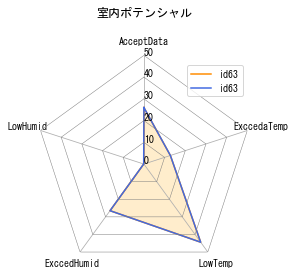

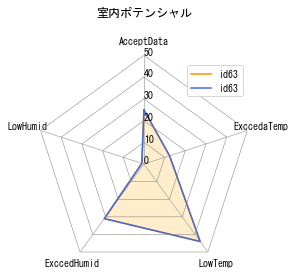

In [11]:
import os
Id=int(63)
BeforeId=int(63)
A=r"C:\therb\木造 1226 id63"+f"/写真{Id},比較id{BeforeId}"
path=A.replace("\\", "/")
dir = path  # 作りたいディレクトリ名
os.makedirs(dir)
print(path)
compareTempIndoor1data(Id,path)
compareHumidIndoor1data(Id,path)
potencialOutdoorpassiveData(Id,path)
calcUAEffect(Id,path)
compareIndoor1data(Id,path)
Explodebar_UAelement(Id,path)
polygonbar_Outdoorpotencial(Id,path)
EvaluateOutdoorPotencial(Id,path)
Explodebar_UAotherStandard(Id,path)
experimentEvaluateIndoortempPotencial(Id,path)
experimentEvaluateIndoorhumidPotencial(Id,path)
#これだけexcelファイルです。
explodeAdaptiveIndicators(Id,path)
compareTempIndoor2datas(BeforeId,Id,path)
compareHumidIndoor2datas(BeforeId,Id,path)
CompareIndoorpotencial(Id,BeforeId,path)